# Проект для «Викишоп»

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Формирование-и-подготовка-признаков" data-toc-modified-id="Формирование-и-подготовка-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Формирование и подготовка признаков</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Лес-деревьев-решений" data-toc-modified-id="Лес-деревьев-решений-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Лес деревьев решений</a></span></li></ul></li><li><span><a href="#Сравнение-результатов-и-выбор-лучшей-модели" data-toc-modified-id="Сравнение-результатов-и-выбор-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сравнение результатов и выбор лучшей модели</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
import re 
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, make_pipeline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Polina\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Polina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Избавимся от предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
# откроем файл
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
def data_overview(data):
    
    # Выведем первые 5 строчек датасета для лучшего понимания структуры
    display(data.head())
    
    # Выведем информацию о датасете
    display(data.info())
    
    # Построим круговую диаграмму по распределению комментариев
    data['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Распределение комментариев')
    plt.legend(['not toxic', 'toxic'])
    plt.ylabel('')
    plt.show()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

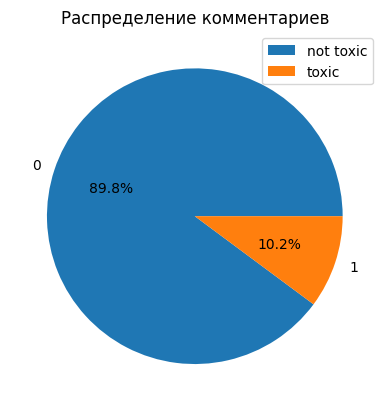

In [5]:
data_overview(data)

In [6]:
# Удалим ненужные столбцы
ata = data[['text', 'toxic']]
# data.head()

Нам доступно 159292 строчек с текстом комментария на английском языке и их разметкой по поводу токсичности, по которым нам предстоит построить модель. Пропуски в данных отсутствуют.  
  
Также, по круговой диаграмме виден большой бисбаланс классов в целевом признаке: токсичные комментарии составляют примерно 10% выборки

Создадим корпус предложений из столбца `text` и напишем функции для подготовки данных

In [7]:
corpus = data['text'].values

In [8]:
def word_tag(nltk_tag):
    tag_dict = {
        'N': wordnet.NOUN,
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(nltk_tag[0].upper(), None)

In [9]:
# Проверим работу функции

#list(map(lambda x: (x[0], word_tag(x[1])), 
         #nltk.pos_tag(['beautiful', 'cat', 'is', 'running', 'quickly'])))

In [10]:
def corrected_sentence_builder(sentence):
    
    # Отделим ненужные символы из текста 
    adjusted = re.sub(r'[^a-zA-Z]', ' ', sentence).split()
    
    # Создадим список отмеченных слов в соответствии с частью речи
    tagged_words = nltk.pos_tag(adjusted)
    tagged_words = list(map(lambda x: (x[0], word_tag(x[1])), tagged_words))
    
    # Лемматизируем предложение
    lemmatized = []
    lemmatizer = WordNetLemmatizer()
    for word, tag in tagged_words:
        if tag is None:
            lemmatized.append(word)
        else:
            lemmatized.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = ' '.join(lemmatized)
    
    return lemmatized_sentence

In [11]:
# Проверим работу функции

# corrected_sentence_builder('beautiful cats are running quickly')

In [12]:
'''
for i in tqdm(range(len(corpus))):
    corpus[i] = corrected_sentence_builder(corpus[i])
'''

'\nfor i in tqdm(range(len(corpus))):\n    corpus[i] = corrected_sentence_builder(corpus[i])\n'

In [13]:
'''
corpus = pd.DataFrame(corpus)
corpus.columns = ['lemmatized_text']
corpus.head()
corpus.to_csv('/Users/Polina/Downloads/corpus')
'''

"\ncorpus = pd.DataFrame(corpus)\ncorpus.columns = ['lemmatized_text']\ncorpus.head()\ncorpus.to_csv('/Users/Polina/Downloads/corpus')\n"

Так как лемматизация и обработка текста занимает много времени, сохраним обработанный корпус и закомментируем ячейки

In [14]:
corpus_adjusted = pd.read_csv('/Users/Polina/Downloads/corpus')
corpus_adjusted = corpus_adjusted['lemmatized_text'].values.astype('U')
corpus_adjusted = list(corpus_adjusted)
#corpus_adjusted

In [15]:
features = corpus_adjusted
#features

target = data['toxic']
#target

В данном разделе мы:
- изучили данные
- провели предобработку текста
  - убрали ненужные символы
  - лемматизировали текст  
- Разделили выборку на обучающую и тестовую
    
Данные готовы к формированию признаков и построению модели

## Обучение

### Формирование и подготовка признаков

Разделим выборки на тренировочную и тестовую

In [16]:
unadjusted_features_train, unadjusted_features_test, target_train, target_test = (
    train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)
)
#features_train.shape
#features_test.shape
#target_train.shape
#target_test.shape

Создадим признаки на основе модели TF-IDF

In [17]:
# Сохраним стоп слова
stopwords = set(nltk_stopwords.words('english'))

Признаки сформированы и готовы к построению моделей. Так как нам необходимо определить, таксичное ли определенное выражение или нет, перед нами стоит задача бинарной классификации. Рассмотрим следующие модели:
- логистическая регрессия
- дерево решений
- лес деревьев решений

### Логистическая регрессия

Подберем лучшее значение гипермараметра С для модели логистической регрессии

In [18]:
'''
%%time

f1_regression = 0
c = 0

for i in tqdm(np.arange(0.5, 3.5, 0.5)):
    pipe_lr = Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words=stopwords)),
        ('regression', LogisticRegression(class_weight='balanced', C=i, random_state=12345))
    ])
    score = cross_val_score(pipe_lr, unadjusted_features_train, 
                                    target_train, scoring='f1', cv=5).mean()
    if score > f1_regression:
        f1_regression = score
        c = i

print(f'Показатель c для лучшей модели: {c}\n'
     f'Значение F1 для логистической регрессии: {f1_regression}')
'''

"\n%%time\n\nf1_regression = 0\nc = 0\n\nfor i in tqdm(np.arange(0.5, 3.5, 0.5)):\n    pipe_lr = Pipeline([\n        ('vectorizer', TfidfVectorizer(stop_words=stopwords)),\n        ('regression', LogisticRegression(class_weight='balanced', C=i, random_state=12345))\n    ])\n    score = cross_val_score(pipe_lr, unadjusted_features_train, \n                                    target_train, scoring='f1', cv=5).mean()\n    if score > f1_regression:\n        f1_regression = score\n        c = i\n\nprint(f'Показатель c для лучшей модели: {c}\n'\n     f'Значение F1 для логистической регрессии: {f1_regression}')\n"

Чтобы не прогонять модель каждый раз, что занимает много времени, сразу сохраним получившийся результат

In [19]:
# Результаты лучшей модели LogosticRegression
c = 3
regression_time = '4min 43s'
f1_regression = 0.7548644490046963
regression = LogisticRegression(class_weight='balanced', C=c, random_state=12345)

print(f'Показатель c для лучшей модели: {c}\n'
     f'Значение F1 для логистической регрессии: {f1_regression}\n'
     f'Время рассчета модели: {regression_time}')

Показатель c для лучшей модели: 3
Значение F1 для логистической регрессии: 0.7548644490046963
Время рассчета модели: 4min 43s


### Дерево решений

In [20]:
'''
%%time

best_depth = 0
min_splits = 0
f1_tree = 0
tree = None

for i in tqdm(range(1, 6)):
    for splits in range(2, 6):
        pipe_tree = Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words=stopwords)),
        ('tree', DecisionTreeClassifier(max_depth=i, min_samples_split=splits, class_weight='balanced',
                                        random_state=12345))
    ])
        score = cross_val_score(pipe_tree, unadjusted_features_train, 
                                target_train, scoring='f1', cv=5).mean()
        
        if score > f1_tree:
            min_splits = splits
            best_depth = i
            f1_tree = score
            
print(f'Максимальная глубина дерева на лучшей модели: {best_depth}\n'
      f'Минимальное количество выборок для разделения узла: {min_splits}\n'
        f'Значение F1 для модели дерева решений: {f1_tree}')
'''

"\n%%time\n\nbest_depth = 0\nmin_splits = 0\nf1_tree = 0\ntree = None\n\nfor i in tqdm(range(1, 6)):\n    for splits in range(2, 6):\n        pipe_tree = Pipeline([\n        ('vectorizer', TfidfVectorizer(stop_words=stopwords)),\n        ('tree', DecisionTreeClassifier(max_depth=i, min_samples_split=splits, class_weight='balanced',\n                                        random_state=12345))\n    ])\n        score = cross_val_score(pipe_tree, unadjusted_features_train, \n                                target_train, scoring='f1', cv=5).mean()\n        \n        if score > f1_tree:\n            min_splits = splits\n            best_depth = i\n            f1_tree = score\n            \nprint(f'Максимальная глубина дерева на лучшей модели: {best_depth}\n'\n      f'Минимальное количество выборок для разделения узла: {min_splits}\n'\n        f'Значение F1 для модели дерева решений: {f1_tree}')\n"

Так как модель долго считалась, прогоним ее один раз на поиск лучшего набора гиперпараметров и сохраним результат, закомментировав ячейку

In [21]:
# Результаты лучшей модели DecisionTreeClassifier
f1_tree = 0.4838211278190695
tree_time = '11min 2s'
max_depth_tree = 5
min_splits_tree = 2
tree = DecisionTreeClassifier(max_depth=max_depth_tree, min_samples_split=min_splits_tree, 
                              random_state=12345)

print(f'Максимальная глубина дерева на лучшей модели: {max_depth_tree}\n'
      f'Минимальное количество выборок для разделения узла: {min_splits_tree}\n'
        f'Значение F1 для модели дерева решений: {f1_tree}\n'
     f'Время рассчета модели: {tree_time}')

Максимальная глубина дерева на лучшей модели: 5
Минимальное количество выборок для разделения узла: 2
Значение F1 для модели дерева решений: 0.4838211278190695
Время рассчета модели: 11min 2s


### Лес деревьев решений

In [22]:
'''
%%time

best_depth_forest = 0
f1_forest = 0
forest = None

for i in tqdm(range(1, 6)):
    for trees in [50, 100, 200]:
        pipe_forest = Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words=stopwords)),
            ('forest', RandomForestClassifier(max_depth=i, n_estimators=trees, class_weight='balanced', 
                                       random_state=12345))
        ])
        score = cross_val_score(pipe_forest, unadjusted_features_train, target_train, 
                                scoring='f1', cv=5).mean()
        
        if score > f1_forest:
            best_depth_forest = i
            num_of_trees = trees
            f1_forest = score
            
print(f'Максимальная глубина леса на лучшей модели: {best_depth_forest}\n'
        f'Количество деревьев в лесу: {num_of_trees}\n'
     f'Значение F1 для модели леса решений: {f1_forest}')
'''

"\n%%time\n\nbest_depth_forest = 0\nf1_forest = 0\nforest = None\n\nfor i in tqdm(range(1, 6)):\n    for trees in [50, 100, 200]:\n        pipe_forest = Pipeline([\n            ('vectorizer', TfidfVectorizer(stop_words=stopwords)),\n            ('forest', RandomForestClassifier(max_depth=i, n_estimators=trees, class_weight='balanced', \n                                       random_state=12345))\n        ])\n        score = cross_val_score(pipe_forest, unadjusted_features_train, target_train, \n                                scoring='f1', cv=5).mean()\n        \n        if score > f1_forest:\n            best_depth_forest = i\n            num_of_trees = trees\n            f1_forest = score\n            \nprint(f'Максимальная глубина леса на лучшей модели: {best_depth_forest}\n'\n        f'Количество деревьев в лесу: {num_of_trees}\n'\n     f'Значение F1 для модели леса решений: {f1_forest}')\n"

Сразу сохраним результаты расчетов и гиперпараметры лучшей модели, закомментировав ячейку

In [23]:
# Результаты лучшей модели RandomForestRegressor
f1_forest = 0.3357805715833218
forest_time = '8min 55s'
trees = 200
max_depth_forest = 5
forest = RandomForestClassifier(max_depth=max_depth_forest, n_estimators=trees, 
                                class_weight='balanced', random_state=12345)

print(f'Максимальная глубина дерева на лучшей модели: {max_depth_forest}\n'
        f'Значение F1 для модели дерева решений: {f1_forest}\n'
      f'Количество деревьев в лесу: {trees}\n'
     f'Время рассчета модели: {forest_time}')

Максимальная глубина дерева на лучшей модели: 5
Значение F1 для модели дерева решений: 0.3357805715833218
Количество деревьев в лесу: 200
Время рассчета модели: 8min 55s


## Сравнение результатов и выбор лучшей модели

In [24]:
f1_table = pd.DataFrame(
    {
        'Модель': ['Логистическая регрессия', 'Дерево решений', 'Лес деревьев решений'],
        'F1 на кросс-валидации': [f1_regression, f1_tree, f1_forest],
        'Время подбора лучшей модели': [regression_time, tree_time, forest_time]
    }
)
f1_table = f1_table.set_index('Модель')
f1_table

,F1 на кросс-валидации,Время подбора лучшей модели
Модель,,
Логистическая регрессия,0.754864,4min 43s
Дерево решений,0.483821,11min 2s
Лес деревьев решений,0.335781,8min 55s


Логистическая регрессия выигрывает по скорости подбора гиперпараметров и по мерке F1. Проверим данную модель на тестовой выборке

## Тестирование модели

In [25]:
# Создадим счетчик, обучим его на тренировочной выборке и преобразуем признаки тестовой выборки
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(unadjusted_features_train)
features_test = count_tf_idf.transform(unadjusted_features_test)

# Оценим качество модели на тестовой выборке
regression.fit(features_train, target_train)
predictions = regression.predict(features_test)
f1_test = f1_score(target_test, predictions)

print(f'Значение F1 на тестовой выборке: {f1_test}')

Значение F1 на тестовой выборке: 0.7588218949708252


Показатель F1 на тестовой выборке прошел пороговое значение (не меньше 0.75). Следовательно, цель проекта была выполнена, и проект может быть презентован заказчику

## Выводы

Подводя итоги, целью данного проекта было разработать модель, классифицирующую предложения по токсичности/не токсичности со значением F1 не менее 0.75.  
  
Сначала мы открыли файл и изучили представленные данные. Пропусков в данных не было обнаружено, и был замечен большой дисбаланс данных, что мы в дальнейшем учли при построении моделей. В процессе предобработки данных мы также создали корпус фраз, изменив тип данных, лемматизировали текст и очистили от ненужных слов (не несущих смысловой нагрузки).  
  
Далее мы подготовили данные к построению моделей:
- разделили датасет на обучающую и тестовую выборки
- создали признаки на основе TF-IDF  
  
Так как перед нами стояла задача классификации, мы рассмотрели следующие модели:
- логистическая регрессия
- дерево решений
- лес деревьев решений  
  
Модель логистической регрессии показала наилучший результат мерки F1 на методе кросс-валидации, пройдя бенчмарк в 0.75 с примерным значением 0.754864, и показала наиболее быстрое время подбора гиперпараметра - 4 минуты и 43 секунды. На тестовой выборке модель также прошла пороговое значение F1 с результатом около  0.758822. Следовательно, цель проекта была выполнена, и модель может быть представлена заказчику.